In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

In [3]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('AAPL.csv')


In [4]:

from pyspark.sql.types import DoubleType
data = data.withColumn("Open", data["Open"].cast(DoubleType()))
data = data.withColumn("Date", data["Date"].cast(DoubleType()))
data = data.withColumn("High", data["High"].cast(DoubleType()))
data = data.withColumn("Low", data["Low"].cast(DoubleType()))
data = data.withColumn("Close", data["Close"].cast(DoubleType()))
data = data.withColumn("Adj Close", data["Adj Close"].cast(DoubleType()))
data = data.withColumn("Volume", data["Volume"].cast(DoubleType()))

In [5]:
data.printSchema() 

root
 |-- Date: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)



In [7]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Date,9534,9.413206708621775E8,3.445064029577415E8,3.454164E8,1.5384276E9
Open,9533,25.227877389069594,45.035747904623484,0.198661,228.990005
High,9533,25.46629224934435,45.402302820535645,0.198661,230.0
Low,9533,24.976618823979813,44.669427190260855,0.196429,226.630005
Close,9533,25.227376554914493,45.04640919574818,0.196429,229.279999
Adj Close,9533,23.66256029403127,43.507792038119455,0.158904,229.279999
Volume,9533,8.787442552187139E7,8.695796711275896E7,347200.0,1.8554102E9


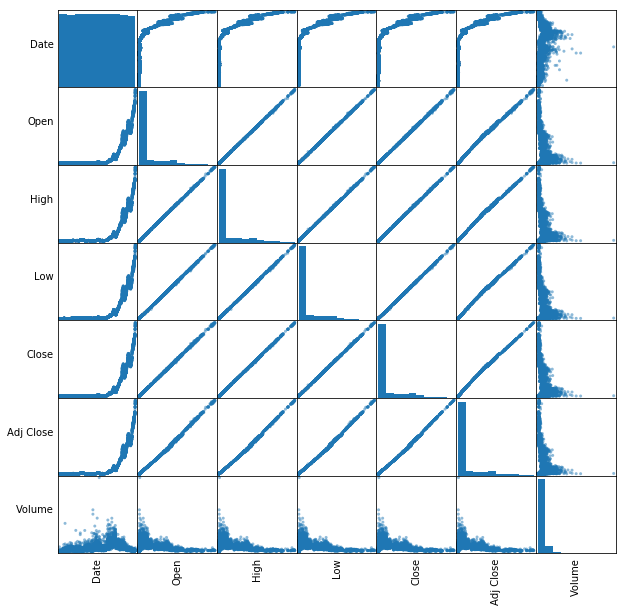

In [14]:
import pandas as pd
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = data.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())


In [15]:
import six
for i in data.columns:
    if not( isinstance(data.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Adj CLose for ", i, data.stat.corr('Adj Close',i))


Correlation to Adj CLose for  Date 0.7251497833701646
Correlation to Adj CLose for  Open 0.9990105404567703
Correlation to Adj CLose for  High 0.999042142224704
Correlation to Adj CLose for  Low 0.9991275168772424
Correlation to Adj CLose for  Close 0.9991303055364779
Correlation to Adj CLose for  Adj Close 1.0
Correlation to Adj CLose for  Volume -0.0878596271018589


In [64]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Date','Open','High', 'Low', 'Close', 'Volume'], outputCol = 'features')
vdata=vectorAssembler.setHandleInvalid("skip").transform(data).select(['features','Adj Close'])
vdata.show(5)

+--------------------+---------+
|            features|Adj Close|
+--------------------+---------+
|[3.454164E8,0.513...| 0.415317|
|[3.456756E8,0.488...| 0.393649|
|[3.45762E8,0.4531...| 0.364757|
|[3.458484E8,0.462...| 0.373786|
|[3.459348E8,0.475...|  0.38462|
+--------------------+---------+
only showing top 5 rows



In [65]:
splits = vdata.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### lr

In [67]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Adj Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.23951182510107658,0.23782637704446413,0.24211699892675834,0.2402773011874203,-3.286491233106089e-09]
Intercept: -0.25848958452813603
